In [1]:
import json, os, sys, wave, pyaudio, wikipedia, numpy as np, matplotlib.pyplot as plt, pyttsx3
from vosk import Model, KaldiRecognizer
from natasha import *
from IPython.display import HTML, clear_output, IFrame
from yandex_music.client import Client

kaldi_recognizer = KaldiRecognizer(
        Model("C:/dev/postnauka/models/vosk-model-ru-0.10"), 22050)
wikipedia.set_lang("ru")

segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
morph_vocab = MorphVocab()
names_extractor = NamesExtractor(morph_vocab)

mus_client = Client()
engine = pyttsx3.init()
voices = engine.getProperty('voices')
for voice in voices:
    if 'RU' in voice.id:
        engine.setProperty('voice', voice.id)
        break
clear_output()
pya = pyaudio.PyAudio()

In [2]:
def записать(player, seconds=7):
    print("Начинаем запись!", end='\t')
    leng = (22050 * seconds)
    stream = player.open(input=True, format=pyaudio.paInt16, channels=1, rate=22050,
                         frames_per_buffer=leng)
    data = stream.read(leng)
    stream.stop_stream()
    stream.close()
    print("Записали!")
    return data

def распознать(frames):
    global kaldi_recognizer
    words = {}
    if kaldi_recognizer.AcceptWaveform(frames): words = json.loads(kaldi_recognizer.Result())
    else: words = json.loads(kaldi_recognizer.PartialResult())
    text = words['text'] if 'text' in words else words ['partial']
    return text

In [3]:
def синтаксический_анализ(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)
    for token in doc.tokens: token.lemmatize(morph_vocab)   
    doc.parse_syntax(syntax_parser)
    doc.sents[0].syntax.print()
    action, dep = None, []
    for tok in doc.tokens:
        if tok.pos == 'VERB' or tok.rel == 'root': 
            action = tok
            break
    for tok in doc.tokens:
        if tok != action: dep.append(tok)
    return action.lemma if action else None, [d.text for d in dep]

def embed(words):
    n = 0
    e = None
    for word in words:
        if word in emb:
            n += 1
            if e is None: e = emb.get(word)
            else: e = e + emb.get(word)
    if n > 0: return e / n
    else: return None
    
def интент(action):
    actions = {
        'включить': 'play',
        'играть': 'play',
        'поставить': 'play',
        'прочитать': 'wiki',
        'рассказать': 'wiki',
        'кто': 'wiki',
        'какой': 'wiki'
    }
    res = []
    for k in actions:
        res.append([emb.sim(action, k), actions[k], k])
    res.sort()
    print("Интент:", res[-1])
    return res[-1][1]

In [4]:
def play(text):
    searchres = mus_client.search(text)
    clear_output()
    display(IFrame(f"https://music.yandex.ru/iframe/#track/{searchres['best']['result']['id']}", width=400, height=80))

def wiki(text):
    wikipedia.set_lang("ru")
    summ = wikipedia.summary(wikipedia.search(text)[0], sentences=3)
    print(summ)
    engine.say(summ)
    engine.runAndWait()

Начинаем запись!	Записали!


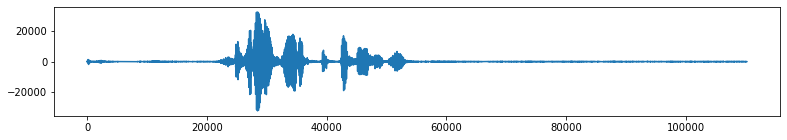

Вы сказали: сыграй город под подошвой
     сыграй   
┌─── город    
│ ┌► под      case
└►└─ подошвой nmod
действие = сыграй	объект = город под подошвой
Интент: [-0.027169278, 'play', 'играть']


In [7]:
сигнал = записать(pya, 5)
plt.figure(figsize=(13, 2))
plt.plot(np.frombuffer(сигнал, np.int16))
plt.show()
text = распознать(сигнал)
print("Вы сказали:", text)
что_делать, с_чем = синтаксический_анализ(text)
print(f"действие = {что_делать}\tобъект = {' '.join(с_чем)}")
intent_ = интент(что_делать)

In [8]:
if intent_ == 'wiki': wiki(' '.join(с_чем))
elif intent_ == 'play': play(' '.join(с_чем))